# Graham Dominick
## Data Science Final Project

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Motivation:

## I've always been interested in sports, particularly NBA basketball. NBA teams have recently started taking advantage of statistical methods to improve performance, or play more efficiently. This has really changed the way the game is played, and has lead to entirely new offensive strategies. 

## For my final project I will be doing some of my own statistical analysis on NBA teams, asking, what what factors lead to winning records in the regular season. I have downloaded a dataset from https://data.world/gmoney/nba-team-records-by-year that specifies the win percentage of every NBA team from every season since 1950 (1417 records total).

In [2]:
win_loss = pd.read_csv("win_loss_data.csv", usecols=[0,1,2,3])
#win_loss.dropna(subset=["Year"], inplace=True)
display(win_loss.iloc[np.random.choice(len(win_loss), 5)])

,Year,Team,Record,Winning Percentage
1035,2003-04,76ers,33-49,0.402
379,1979-80,Nuggets,30-52,0.366
983,1977-78,Supersonics,47-35,0.573
1219,1983-84,Kings,38-44,0.463
957,2003-04,Supersonics,37-45,0.451


## NBA basketball is arguably the quintessential "superstar" sport. Stars in basketball can make an impact on their teams success unlike star players in any of the other main American professional sports (football, hockey, baseball). Just look at the dropoff in win percentage when Lebron James left the Cleveland Cavaliers for the Miami Heat in 2010.

In [3]:
print(win_loss.iloc[[267, 266, 265, 264, 263, 262]])

          Year       Team Record  Winning Percentage
267    2007-08  Cavaliers  45-37               0.549
266    2008-09  Cavaliers  66-16               0.805
265    2009-10  Cavaliers  61-21               0.744
264    2010-11  Cavaliers  19-63               0.232
263  2011-12 *  Cavaliers  21-45               0.318
262    2012-13  Cavaliers  24-58               0.293


## Because of this, I want to correlate individual player statistics to a team's winning percentage, and determine which individual metrics best predict team success.

# Goals for this Project

## 1. Generate as accurate as possible a model for the win % of an NBA team for 1990-2017 based on player statistics.

## 2. Look for trends in chunks of time (decades for example) and see if a different model is more effective for a certain decade. e.g. Most experts say that the 3 pointer has become the most important shot in basketball in recent years, I could test this by comparing it's relative importance in the models of different decades.


## I will be combining two datasets for this project. I described the team statistics dataset above.

## For player statistics I will be using a dataset of statistics for ~3900 different players, and ~23000 different seasons which also goes back to 1950 from Kaggle. https://www.kaggle.com/drgilermo/nba-players-stats/data 

In [4]:
player_stats = pd.read_csv("season_stats.csv")
print(player_stats.columns)

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


## This dataset contains lots of statistics on players, ranging from simple ones, like minutes played or points scored, to more complex statistics like true shooting percentace (TS%), player efficiency rating (PER), win shares, box plus/minus, and value over replacement player (VORP).

In [5]:
display(player_stats.columns)

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## I'll explain some of these complex metrics later on, but for now, let's trim down this dataset by dropping some columns that we don't need.

#### We can drop games played (G) and games started (GS) in favor of minutes played (MP), a more precise measure of playing time.
#### Stats like assist % (AST%), rebound % ( ORB%, DRB%, TRB%), usage % (USG%), are factored into the advanced metrics (BPM and PER), so we can use those instead
#### The shooting percentage stats (3P%, 2P%, eFG%, FT%, etc.) are encapsulated by true shooting percentage (TS%) so we can also drop those.
#### Win shares are a measure of how much a player contributued to a team's win. So a player's win shares are directly propotional to the number of wins by their team. We want to focus on purely individual statistics, so we can throw that out.

In [6]:
player_stats.drop(columns=['Unnamed: 0', 'Pos', 'G', 'GS', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 
                           'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'blanl', 'DWS', 'blank2',
                           'OBPM', 'DBPM', 'FG', 'FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 
                           'eFG%', 'FTA', 'ORB', 'DRB', 'WS', 'WS/48'], inplace=True)

## Here are the columns we're left with. The player's names aren't necessary for analysis, but are helpful metadata, especially for making sure the cleaning process goes right, and for providing anecdotal analysis. "GA-SW" stands for offensive win shares, and was unable to be dropped from the table due to the hyphen in the name.

## Year and Team will be used as categorical variables to match a player's statistics to a specific team and season. The remaining 17 columns are numerical and will be used for modeling. 

##  12 of these fields are discrete: Age, MP, 3P, 2P, FT, TRB, AST, STL, BLK, TOV, PF, and PTS, and the remaining 5 are continuous: PER, TS%, BPM, VORP, FT%.

In [7]:
display(player_stats.columns)

Index(['Year', 'Player', 'Age', 'Tm', 'MP', 'PER', 'TS%', 'OWS', 'BPM', 'VORP',
       '3P', '2P', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'],
      dtype='object')

## For the team statistics dataset, the only columns that we care about are the team and year, for matching up with players, and the winning percentage.

# =============================================================

## First, we need to join the datasets in a way that makes sense for the analysis we want to do. For each team/season, I'm going to add statistics for the top 5 players per team, based on number of minutes played that season. To do, that, we first need to do some serious cleaning and reformatting...

# Cleaning and Reformatting

## There are some blank rows in the players dataset that make it prettier in spreadsheet form. Let's get rid of those rows

In [8]:
player_stats.dropna(subset=["Year", "Player"], inplace=True)

## The "Golden age" of the NBA is generally considered to be the 1990's, so for that reason, and to simplify the analysis a bit, I am going to restrict analysis to NBA seasons later than 1990

In [9]:
player_stats = player_stats[player_stats.Year >= 1990]
player_stats = player_stats[player_stats.Tm != 'TOT']

## The year column in the team statistics dataset reflects a real NBA season, which runs from October of a given year until April of the following year. The years are formatted as 2012-2013, for example. The players dataset provides the latter of the two years, so we need to reformat the team statistics dataset before we can join them.

In [10]:
def season_refmt1(datestr):
    year = datestr[5:7]
    return year

def season_refmt2(year):
    if year >= 30:
        year += 1900
    else: 
        year += 2000
    return year

win_loss["Year"] = win_loss["Year"].apply(season_refmt1)
win_loss["Year"] = win_loss["Year"].astype(int)
win_loss["Year"] = win_loss["Year"].apply(season_refmt2)

## Now we can get rid of team statistics for seasons before 1990

In [11]:
win_loss = win_loss[win_loss["Year"] >= 1990].reset_index()

## We can also get rid of several columns that we won't need. We can use total rebounds (TRB) instead of the offensive (ORB) and defensive (DRB) separately. Also, since we have a column for true shooting percentage (TS%), we don't really need to keep track of the number of 2 and 3 pointers attempted, only the number that were made.

### In order to join the datasets on a year, we need to reformat the player stats year column as an int. Also, some players have asterisks next to their names if they played for multiple teams during a season, let's get rid of those.

In [12]:
player_stats.Year = player_stats.Year.astype(int)

def name_refmt(name):
    return name.strip('*')

player_stats["Player"] = player_stats["Player"].apply(name_refmt)

## Finally, in order to use the stats model formula API, the names of the parameters cannot begin with a number (3P) or have any spaces or percent symbols('Winning Percentage', 'FT%', ). So we need to remane these columns.


In [13]:
win_loss = win_loss.rename({'Winning Percentage': 'Win_Pct'}, axis='columns')
player_stats = player_stats.rename({'TS%': 'TSP', '2P': 'TWOP', '3P': 'THRP', 'FT%': 'FTP'}, axis='columns')

## Let's take a look at our cleaned datasets, before we combine them.

In [14]:
display(win_loss.iloc[np.random.choice(len(win_loss), 10)])


,index,Year,Team,Record,Win_Pct
379,678,2000,Lakers,67-15,0.817
247,408,1992,Pistons,48-34,0.585
758,1319,2016,Jazz,40-42,0.488
224,385,2015,Pistons,32-50,0.390
142,262,2013,Cavaliers,24-58,0.293
185,324,1998,Mavericks,20-62,0.244
466,807,1991,Bucks,48-34,0.585
359,639,1992,Clippers,45-37,0.549
334,614,2017,Clippers,29-16,0.644
457,798,2000,Bucks,42-40,0.512


In [15]:
display(player_stats.iloc[np.random.choice(len(win_loss), 10)])

,Year,Player,Age,Tm,MP,PER,TSP,OWS,BPM,VORP,THRP,TWOP,FT,FTP,TRB,AST,STL,BLK,TOV,PF,PTS
9783,1990,Lewis Lloyd,30.0,PHI,10.0,-20.4,0.500,-0.1,-22.9,-0.1,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,4.0,3.0,2.0
10381,1991,Terry Teagle,30.0,LAL,1498.0,12.8,0.488,0.7,-4.6,-1.0,0.0,335.0,145.0,0.819,181.0,82.0,31.0,8.0,83.0,165.0,815.0
9762,1990,Larry Krystkowiak,25.0,MIL,381.0,7.6,0.423,-0.3,-5.5,-0.3,0.0,43.0,26.0,0.788,76.0,25.0,10.0,2.0,19.0,41.0,112.0
10104,1991,Byron Dinkins,23.0,SAS,144.0,4.5,0.460,-0.2,-8.0,-0.2,0.0,13.0,8.0,0.889,11.0,19.0,2.0,0.0,13.0,12.0,34.0
10246,1991,Grant Long,24.0,MIA,2514.0,12.2,0.554,2.0,1.8,2.4,1.0,275.0,181.0,0.787,568.0,176.0,119.0,43.0,156.0,295.0,734.0
10289,1991,Ken Norman,26.0,LAC,2309.0,16.4,0.526,2.2,0.8,1.6,6.0,514.0,173.0,0.629,497.0,159.0,63.0,63.0,139.0,192.0,1219.0
9877,1990,David Rivers,25.0,LAC,724.0,9.9,0.473,-0.8,-5.2,-0.6,0.0,80.0,59.0,0.756,85.0,155.0,31.0,0.0,88.0,53.0,219.0
10044,1991,Mookie Blaylock,23.0,NJN,2585.0,13.1,0.455,-0.7,-0.5,1.0,14.0,418.0,139.0,0.790,249.0,441.0,169.0,40.0,207.0,180.0,1017.0
10420,1991,Jayson Williams,22.0,PHI,508.0,8.0,0.490,-0.4,-6.9,-0.6,1.0,71.0,37.0,0.661,111.0,16.0,9.0,6.0,40.0,92.0,182.0
9628,1990,Adrian Dantley,33.0,DAL,1300.0,15.4,0.556,2.2,-1.2,0.3,0.0,231.0,200.0,0.787,172.0,80.0,20.0,7.0,75.0,99.0,662.0


# =============================================================

# Data Grouping

## The two datasets use different representations for the team names, which we can map with a dictionary.

In [16]:
print(win_loss.Team.unique())
print(player_stats.Tm.unique())

['Celtics' 'Hawks' 'Nets' 'Hornets' 'Bobcats' 'Bulls' 'Cavaliers'
 'Mavericks' 'Nuggets' 'Pistons' 'Warriors' 'Rockets' 'Pacers' 'Clippers'
 'Lakers' 'Grizzlies' 'Heat' 'Bucks' 'Timberwolves' 'Pelicans' 'Knicks'
 'Thunder' 'Supersonics' 'Magic' '76ers' 'Suns' 'Trail Blazers' 'Kings'
 'Spurs' 'Raptors' 'Jazz' 'Wizards' 'Bullets']
['ORL' 'DEN' 'DET' 'SAC' 'WSB' 'DAL' 'MIL' 'CHH' 'PHI' 'SAS' 'CHI' 'BOS'
 'UTA' 'LAC' 'SEA' 'ATL' 'PHO' 'CLE' 'GSW' 'NJN' 'HOU' 'MIN' 'POR' 'LAL'
 'NYK' 'MIA' 'IND' 'VAN' 'TOR' 'WAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC' 'BRK'
 'NOP' 'CHO']


In [17]:
tm_abrvs = {'ORL': 'Magic', 'DEN': 'Nuggets', 'DET': 'Pistons', 'SAC': 'Kings', 'WSB': 'Bullets', 'DAL': 'Mavericks',
            'MIL': 'Bucks', 'CHH': 'Hornets', 'PHI': '76ers',   'SAS': 'Spurs', 'CHI': 'Bulls', 'BOS': 'Celtics', 'UTA': 'Jazz', 
            'LAC': 'Clippers', 'SEA': 'Supersonics', 'ATL': 'Hawks', 'PHO': 'Suns', 'CLE': 'Cavaliers', 'GSW': 'Warriors',
            'NJN': 'Nets', 'HOU': 'Rockets', 'MIN': 'Timberwolves', 'POR': 'Trail Blazers', 'LAL': 'Lakers',
            'NYK': 'Knicks', 'MIA': 'Heat', 'IND': 'Pacers', 'VAN': 'Grizzlies', 'TOR': 'Raptors', 'WAS': 'Wizards',
            'MEM': 'Grizzlies', 'NOH': 'Hornets', 'CHA': 'Bobcats', 'NOK': 'Hornets', 'OKC': 'Thunder', 'BRK': 'Nets',
            'NOP': 'Pelicans', 'CHO': 'Hornets'}

## We will perform analysis on the players that had the most impact on their teams in terms of minutes played. We could pick the top n players by minutes played for each team for any number n up to the size of a team, but we would see diminishing returns, as most teams stick with a core rotation of <10 players. From my experience adjusting n, the top 7 players is a good number for analysis without overcomplicating things. 

## We can use pandas groupby, and the apply nlargest functions to get the top 7 players per team in terms of minutes played.

In [18]:
top_7_by_team = player_stats.groupby(['Year','Tm']).apply(lambda x: x.nlargest(7,['MP'])).reset_index(drop=True)

## We now want to sort these 7 players by performance, because the best player on a team may not play the most minutes. This way we can compare teams' best player, second best player, etc. and the impact they had on the number of team wins.

In [19]:
top_7_by_team = top_7_by_team.groupby(['Year','Tm']).apply(lambda x: x.nlargest(7,['BPM'])).reset_index(drop=True)
display(top_7_by_team.head(100))

,Year,Player,Age,Tm,MP,PER,TSP,OWS,BPM,VORP,THRP,TWOP,FT,FTP,TRB,AST,STL,BLK,TOV,PF,PTS
0,1990,Doc Rivers,28.0,ATL,1526.0,17.2,0.539,2.5,4.1,2.4,24.0,194.0,138.0,0.812,200.0,264.0,116.0,22.0,98.0,151.0,598.0
1,1990,Dominique Wilkins,30.0,ATL,2888.0,24.6,0.556,9.3,3.7,4.2,59.0,751.0,459.0,0.807,521.0,200.0,126.0,47.0,174.0,141.0,2138.0
2,1990,Moses Malone,34.0,ATL,2735.0,20.2,0.564,6.0,1.0,2.1,1.0,516.0,493.0,0.781,812.0,130.0,47.0,84.0,232.0,158.0,1528.0
3,1990,Cliff Levingston,29.0,ATL,1706.0,12.1,0.540,2.4,0.5,1.1,1.0,215.0,83.0,0.680,319.0,80.0,55.0,41.0,49.0,216.0,516.0
4,1990,Spud Webb,26.0,ATL,2184.0,15.3,0.538,3.5,-0.2,1.0,1.0,293.0,162.0,0.871,201.0,477.0,105.0,12.0,141.0,185.0,751.0
5,1990,Kevin Willis,27.0,ATL,2273.0,15.7,0.551,3.0,-1.2,0.5,2.0,416.0,168.0,0.683,645.0,57.0,63.0,47.0,144.0,259.0,1006.0
6,1990,John Battle,27.0,ATL,1477.0,12.6,0.542,1.7,-3.2,-0.5,2.0,273.0,102.0,0.756,99.0,154.0,28.0,3.0,89.0,115.0,654.0
7,1990,Larry Bird,33.0,BOS,2944.0,21.9,0.546,5.3,6.1,6.1,65.0,653.0,319.0,0.930,712.0,562.0,106.0,61.0,243.0,173.0,1820.0
8,1990,Kevin McHale,32.0,BOS,2722.0,21.8,0.623,7.8,3.7,3.9,23.0,625.0,393.0,0.893,677.0,172.0,30.0,157.0,183.0,250.0,1712.0
9,1990,Reggie Lewis,24.0,BOS,2522.0,16.8,0.545,4.2,1.4,2.1,4.0,536.0,256.0,0.808,347.0,225.0,88.0,63.0,120.0,216.0,1340.0


# =============================================================

# Exploratory Data Analysis

## First let's take a glance at the range of statistics for these players using boxplots. I'll also use this as an opportunity to discuss the statistics and what they stand for

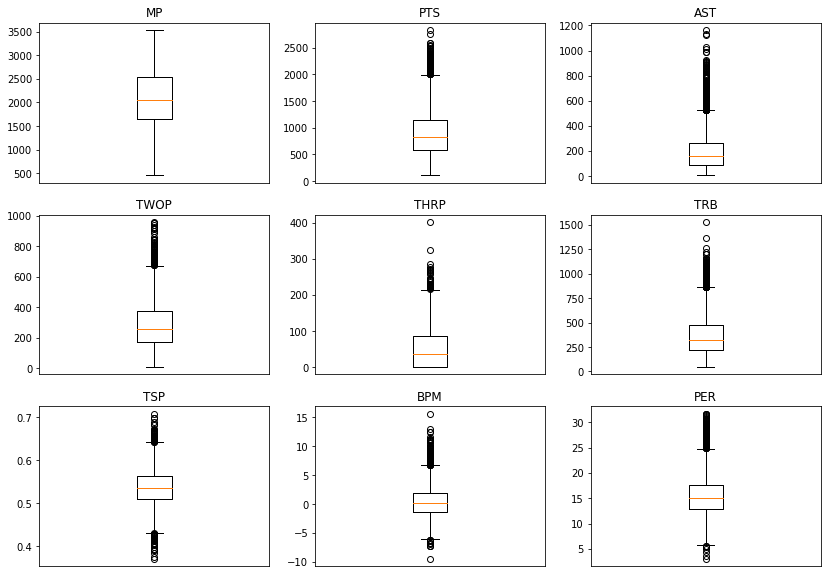

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
fields = ['MP', 'PTS', 'AST', 'TWOP', 'THRP', 'TRB', 'TSP', 'BPM', 'PER']
for i in range(3):
    for j in range(3):
        ax[i,j].boxplot(top_7_by_team[fields[3*i + j]])
        ax[i,j].set_title(fields[3*i + j])
        ax[i,j].tick_params(axis='x', bottom=False, labelbottom=False)

## MP - Minutes Played

## PTS stands for points: This appears to be right-skewed, as there are no outliers for small point totals, but there are numerous outliers for large point totals. I expect that teams with individuals with very high point totals will have higher win percentages, because these tend to be superstar players.

## AST - Assists

## TOV - Turnovers

## TRB - Total (offensive + defensive) rebounds

## BPM stands for Box Plus Minus. 

## PER stands for Player Efficiency Rating. It is a complex stat aimed at boiling the sum of a player's statistical contributions into one number. It normalizes a players stats based on the pace of that players team, and every other player in the league. A PER of 15 is intended to represent an average player. A PER of less than ten would generally indicate a player who is on the fringe of being on the team. Not surprisingly we don't see too many players below 10, and that makes sense given that bad players wouldn't be given many minutes. PERs of > 25 signify a player who has a good chance of winning the Most Valuable Player (MVP) award, and PERs above 30 signify all-time great players. 

## Just like with points, I would expect PER of the top 5 players on a team to correlate highly with win percentage. A team with a player with a PER of 30+ has an MVP-level superstar and will likely win many games.

# Lets also take look at some of the relationships between the statistics, and note any covariance

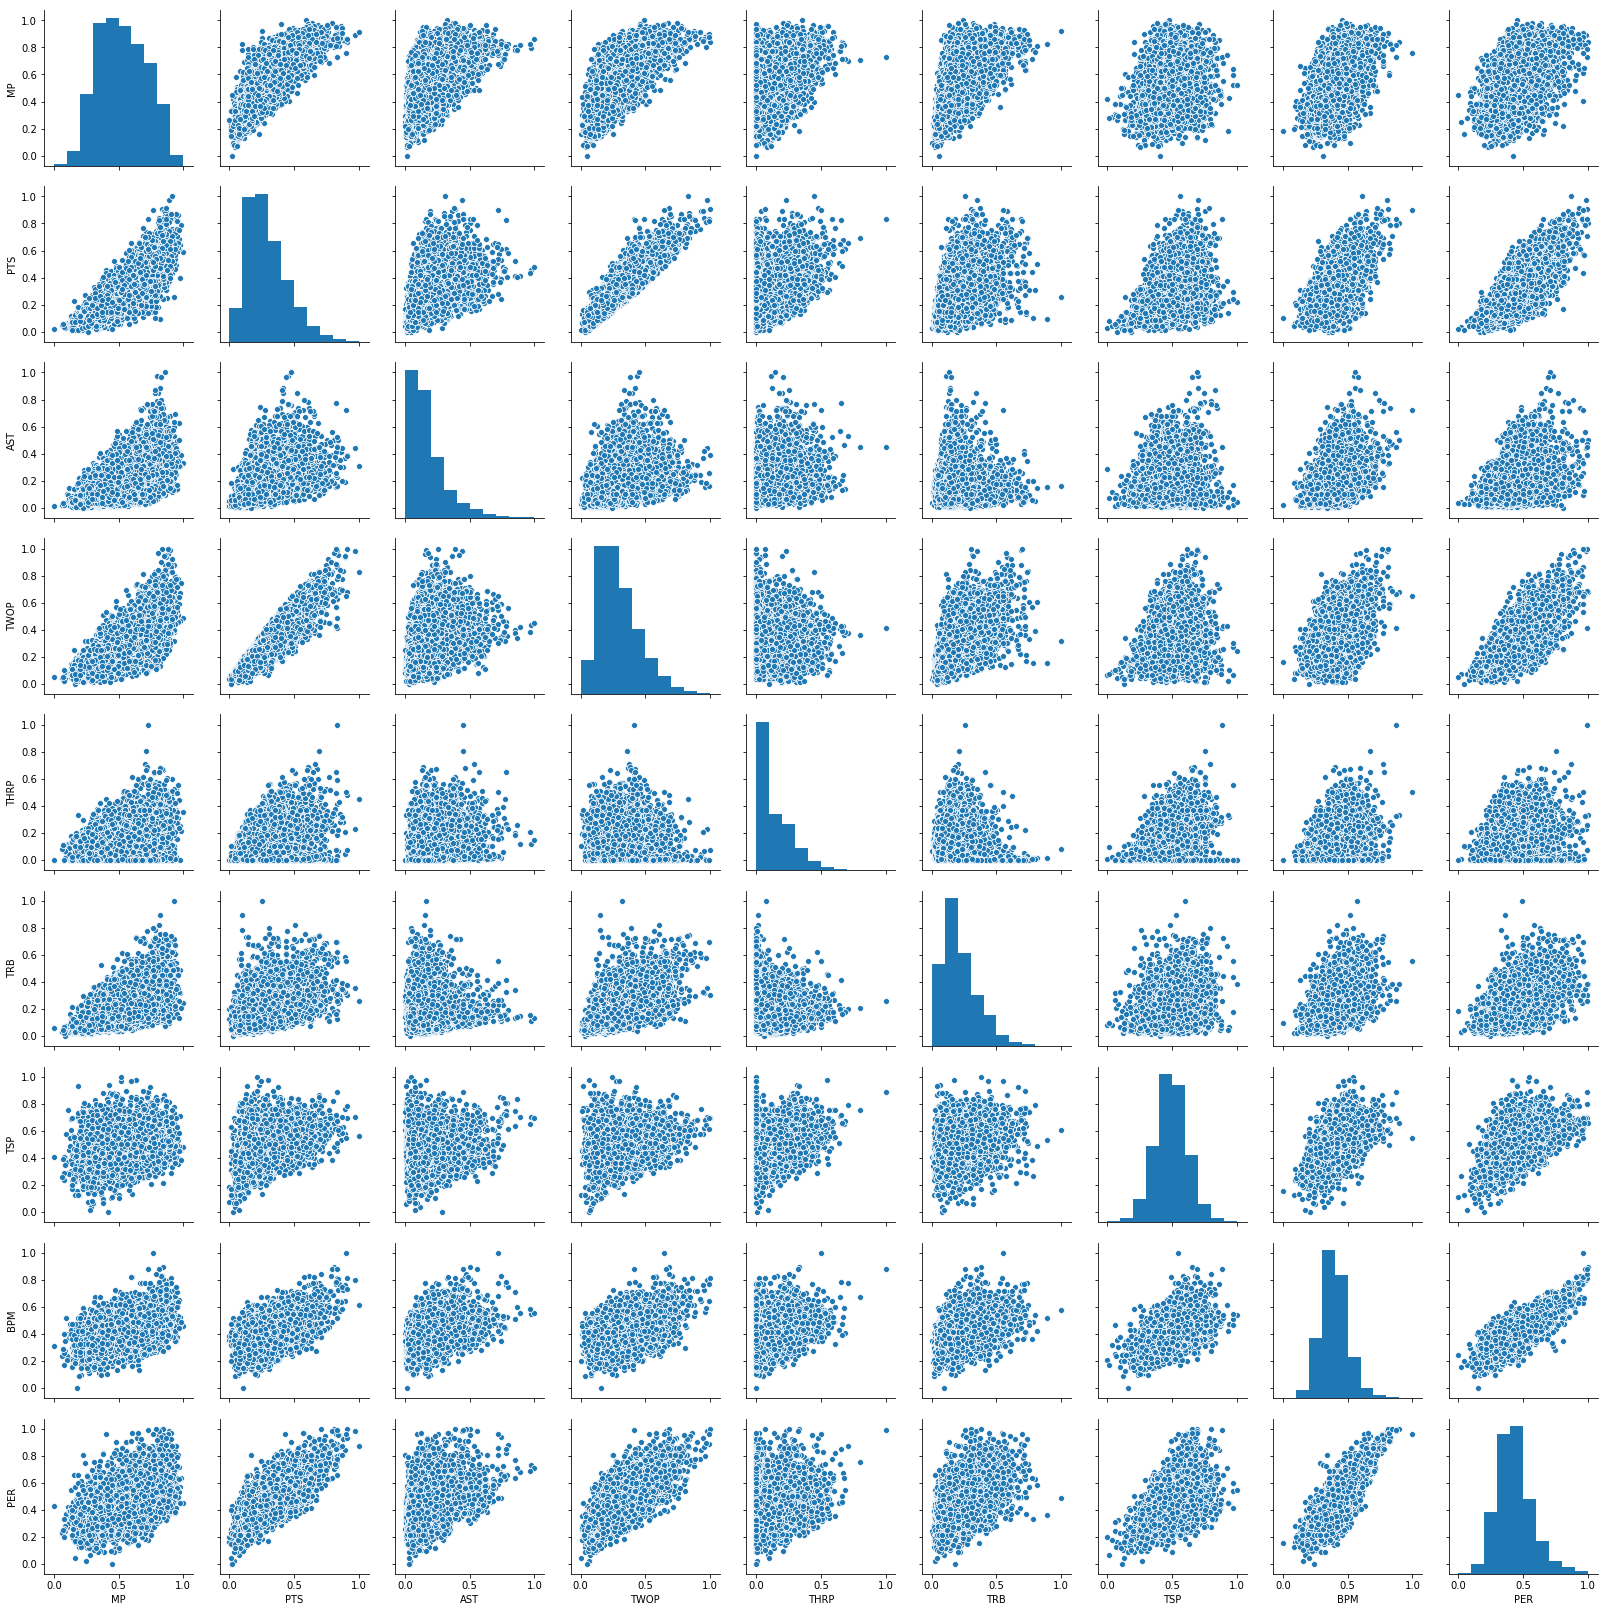

In [21]:
top_7_scaled = top_7_by_team.copy(deep=True)

for attr in fields:
    top_7_scaled[attr] = preprocessing.MinMaxScaler().fit_transform(top_7_scaled[attr].values.reshape(-1,1))

sns.pairplot(top_7_scaled, vars=fields)

## Many of the simple statistics are weakly correlated with minutes played, and with eachother. This makes sense, as players who are on the court more will have more time to score, rebound, assist, etc. Points is highly correlated with 2P, as many players (though not all) get the majority of their points from 2 point shots.

## BPM and PER correlate fairly strongly, which makes sense as they are both compound statistics intended to measure how good a player is overall. They also seem to correlate with points more than with other simple statistics, which indicates that they place a higher emphasis on points than other stats like rebounds, assists, etc.

## Based on this correlation matrix, I won't drop any columns from further analysis purely based on correlation with another column, although I would anticipate a high degree of colinearity, if we were to have, for instance, points and 2P, in the same model

# Joining Datasets

## Now let's combine our two datasets, by adding the player statistics to their respective team/seasons.
## We're going to create a new column in the team dataset for the specific stat of each player. For example, Player0 and PTS2 will correspond to the name of the best player and points scored by the third best player on a team.

In [36]:
# This multilevel index will save us a lot of time accessing rows in the win_loss table
wl_index = {}
for index, row in win_loss.iterrows():
    wl_index[(row.Year, row.Team)] = index
    
fields = ['Player', 'Age', 'BLK', 'STL', 'FTP', 'VORP'] + fields
top_7_grouped = top_7_by_team.groupby(['Year','Tm'])

for (year, team) in top_7_grouped.groups.keys():
    specific_tm = top_7_grouped.get_group((year,team))
    
    for i in range(7):
        player = specific_tm.iloc[i]

        for field in fields:
            win_loss.loc[wl_index[(year,tm_abrvs[team])], field+str(i)] = player[field]


## Let's verify that it worked

In [37]:
display(win_loss.head(20))

,index,Year,Team,Record,Win_Pct,Player0,Age0,BLK0,STL0,FTP0,VORP0,MP0,PTS0,AST0,TWOP0,THRP0,TRB0,TSP0,BPM0,PER0,Player1,Age1,BLK1,STL1,FTP1,VORP1,MP1,PTS1,AST1,TWOP1,THRP1,TRB1,TSP1,BPM1,PER1,Player2,Age2,BLK2,STL2,FTP2,VORP2,MP2,PTS2,AST2,TWOP2,THRP2,TRB2,TSP2,BPM2,PER2,Player3,Age3,BLK3,STL3,FTP3,VORP3,MP3,PTS3,AST3,TWOP3,THRP3,TRB3,TSP3,BPM3,PER3,Player4,Age4,BLK4,STL4,FTP4,VORP4,MP4,PTS4,AST4,TWOP4,THRP4,TRB4,TSP4,BPM4,PER4,Player5,Age5,BLK5,STL5,FTP5,VORP5,MP5,PTS5,AST5,TWOP5,THRP5,TRB5,TSP5,BPM5,PER5,Player6,Age6,BLK6,STL6,FTP6,VORP6,MP6,PTS6,AST6,TWOP6,THRP6,TRB6,TSP6,BPM6,PER6
0,0,2017,Celtics,25-15,0.625,Isaiah Thomas,27.0,13.0,70.0,0.909,4.8,2569.0,2199.0,449.0,437.0,245.0,205.0,0.625,5.5,26.5,Al Horford,30.0,87.0,52.0,0.800,2.8,2193.0,952.0,337.0,293.0,86.0,464.0,0.553,3.1,17.7,Amir Johnson,29.0,62.0,52.0,0.670,1.7,1608.0,520.0,140.0,186.0,27.0,365.0,0.628,2.2,15.0,Jae Crowder,26.0,23.0,72.0,0.811,2.1,2335.0,999.0,155.0,176.0,157.0,415.0,0.613,1.5,14.9,Kelly Olynyk,25.0,29.0,43.0,0.732,1.0,1538.0,678.0,148.0,192.0,68.0,360.0,0.603,0.7,15.2,Marcus Smart,22.0,34.0,125.0,0.812,1.0,2399.0,835.0,364.0,175.0,94.0,306.0,0.486,-0.3,12.0,Avery Bradley,26.0,11.0,68.0,0.731,0.7,1835.0,894.0,121.0,251.0,108.0,334.0,0.548,-0.5,14.4
1,1,2016,Celtics,48-34,0.585,Isaiah Thomas,26.0,9.0,91.0,0.871,3.3,2644.0,1823.0,509.0,424.0,167.0,243.0,0.562,3.0,21.5,Amir Johnson,28.0,83.0,52.0,0.570,2.3,1800.0,577.0,138.0,239.0,10.0,505.0,0.602,3.0,16.0,Jae Crowder,25.0,35.0,126.0,0.820,2.8,2308.0,1038.0,135.0,238.0,122.0,373.0,0.565,2.8,15.8,Jared Sullinger,23.0,47.0,75.0,0.640,1.5,1915.0,834.0,187.0,322.0,29.0,673.0,0.476,1.1,16.7,Marcus Smart,21.0,18.0,91.0,0.777,1.1,1667.0,558.0,185.0,123.0,61.0,255.0,0.463,0.7,11.3,Avery Bradley,25.0,19.0,117.0,0.780,1.4,2536.0,1155.0,158.0,309.0,147.0,220.0,0.538,0.2,13.2,Evan Turner,27.0,28.0,80.0,0.827,0.8,2271.0,854.0,359.0,323.0,20.0,397.0,0.513,-0.7,13.6
2,2,2015,Celtics,40-42,0.488,Kelly Olynyk,23.0,39.0,64.0,0.684,1.5,1423.0,656.0,109.0,190.0,61.0,303.0,0.558,2.1,15.9,Jared Sullinger,22.0,42.0,44.0,0.744,1.6,1566.0,770.0,134.0,259.0,52.0,441.0,0.503,2.0,17.9,Marcus Smart,20.0,18.0,99.0,0.646,1.4,1808.0,523.0,208.0,84.0,91.0,222.0,0.491,1.1,11.0,Tyler Zeller,25.0,52.0,18.0,0.823,1.2,1731.0,833.0,113.0,340.0,0.0,465.0,0.594,0.9,18.9,Brandon Bass,29.0,32.0,41.0,0.790,0.7,1929.0,866.0,104.0,335.0,9.0,398.0,0.557,-0.5,16.3,Evan Turner,26.0,19.0,83.0,0.752,0.6,2260.0,779.0,449.0,287.0,33.0,417.0,0.482,-1.0,12.8,Avery Bradley,24.0,15.0,82.0,0.790,0.2,2428.0,1071.0,135.0,310.0,124.0,241.0,0.507,-1.7,11.5
3,3,2014,Celtics,25-57,0.305,Kelly Olynyk,22.0,27.0,35.0,0.811,0.9,1400.0,607.0,109.0,194.0,40.0,365.0,0.546,0.5,15.2,Kris Humphries,28.0,61.0,31.0,0.813,0.7,1376.0,579.0,67.0,231.0,0.0,409.0,0.552,0.0,18.2,Jared Sullinger,21.0,49.0,35.0,0.778,0.9,2041.0,982.0,118.0,328.0,56.0,601.0,0.497,-0.3,16.4,Gerald Wallace,31.0,14.0,73.0,0.465,0.6,1416.0,298.0,143.0,97.0,19.0,212.0,0.543,-0.3,10.0,Brandon Bass,28.0,71.0,36.0,0.858,0.5,2266.0,911.0,87.0,350.0,2.0,470.0,0.549,-1.2,15.0,Jeff Green,27.0,47.0,57.0,0.795,0.0,2805.0,1382.0,138.0,347.0,135.0,380.0,0.520,-2.1,13.1,Avery Bradley,23.0,11.0,63.0,0.804,-0.2,1855.0,891.0,85.0,282.0,79.0,226.0,0.510,-2.5,12.7
4,4,2013,Celtics,41-40,0.506,Paul Pierce,35.0,30.0,84.0,0.787,3.4,2575.0,1430.0,370.0,331.0,145.0,487.0,0.559,3.4,19.1,Kevin Garnett,36.0,62.0,78.0,0.786,1.5,2022.0,1004.0,159.0,420.0,2.0,530.0,0.535,1.0,19.2,Courtney Lee,27.0,21.0,89.0,0.861,0.8,1941.0,612.0,143.0,188.0,58.0,190.0,0.545,-0.3,11.7,Jason Terry,35.0,11.0,66.0,0.870,0.7,2124.0,799.0,198.0,158.0,123.0,159.0,0.566,-0.6,12.8,Jeff Green,26.0,68.0,56.0,0.808,0.7,2252.0,1036.0,128.0,306.0,70.0,318.0,0.561,-0.8,15.0,Brandon Bass,27.0,64.0,44.0,0.860,0.4,2239.0,701.0,84.0,286.0,0.0,425.0,0.535,-1.2,12.3,Avery Bradley,22.0,19.0,64.0,0.755,-0.2,1435.0,461.0,104.0,152.0,40.0,111.0,0.461,-2.7,8.8
5,5,2012,Celtics,39-27,0.591,Paul Pierce,34.0,26.0,70.0,0.852,3.4,2075.0,1181.0,274.0,294.0,100.0,317.0,0.567,4.4

### This was a complex dataset to generate, so let's save it to a CSV file

In [38]:
win_loss.to_csv('combined_stats.csv')

# Let's start our regression analysis by seeing which simple statistics contribute the most to win percentage

In [41]:
model_age = smf.ols(formula='Win_Pct~Age0+Age1+Age2+Age3+Age4+Age5+Age6', data=win_loss).fit() 
model_mp = smf.ols(formula='Win_Pct~MP0+MP1+MP2+MP3+MP4+MP5+MP6', data=win_loss).fit()
model_pts = smf.ols(formula='Win_Pct~PTS0+PTS1+PTS2+PTS3+PTS4+PTS5+PTS6', data=win_loss).fit()
model_ast = smf.ols(formula='Win_Pct~AST0+AST1+AST2+AST3+AST4+AST5+AST6', data=win_loss).fit()
model_2p = smf.ols(formula='Win_Pct~TWOP0+TWOP1+TWOP2+TWOP3+TWOP4+TWOP5+TWOP6', data=win_loss).fit()
model_3p = smf.ols(formula='Win_Pct~THRP0+THRP1+THRP2+THRP3+THRP4+THRP5+THRP6', data=win_loss).fit()
model_ftp = smf.ols(formula='Win_Pct~FTP0+FTP1+FTP2+FTP3+FTP4+FTP5+FTP6', data=win_loss).fit()
model_reb = smf.ols(formula='Win_Pct~TRB0+TRB1+TRB2+TRB3+TRB4+TRB5+TRB6', data=win_loss).fit()
model_blk = smf.ols(formula='Win_Pct~BLK0+BLK1+BLK2+BLK3+BLK4+BLK5+BLK6', data=win_loss).fit()
model_stl = smf.ols(formula='Win_Pct~STL0+STL1+STL2+STL3+STL4+STL5+STL6', data=win_loss).fit()

print("Age Model R_Sqared:", model_age.rsquared_adj)
print("Minutes Played Model R_Sqared:", model_mp.rsquared_adj)
print("Points Model R_Sqared:", model_pts.rsquared_adj)
print("Assists Model R_Sqared:", model_ast.rsquared_adj)
print("2 Point Model R_Sqared:", model_2p.rsquared_adj)
print("3 Point Model R_Sqared:", model_3p.rsquared_adj)
print("Free Throw % Model R_Sqared:", model_ftp.rsquared_adj)
print("Rebounds Model R_Sqared:", model_reb.rsquared_adj)
print("Blocks Model R_Sqared:", model_blk.rsquared_adj)
print("Steals Model R_Sqared:", model_stl.rsquared_adj)

Age Model R_Sqared: 0.25074619658017105
Minutes Played Model R_Sqared: 0.09585845417768735
Points Model R_Sqared: 0.18287172353238013
Assists Model R_Sqared: 0.19161349786385728
2 Point Model R_Sqared: 0.09389595478220314
3 Point Model R_Sqared: 0.05503419695167466
Free Throw % Model R_Sqared: 0.024773323910900036
Rebounds Model R_Sqared: 0.1375740838648869
Blocks Model R_Sqared: 0.07656432277777148
Steals Model R_Sqared: 0.0820435600149989


## Surprisingly, the age of a team's starting 5 is more strongly correlated with their win percentage than any other simple stat, even the number of points they score. This could be interpreted as experience in the NBA being a good marker of success. 
## Points and assists are both more strongly correlated with winning than other simple stats. They both give an r squared of ~.16. This makes some sense, given the fact that most points come from an assist. 
## Still, none of these simple stats show much promise for predicting win rate for a team on their own. Let's look at some complex stats and see if they can help us.

In [42]:
model_tsp = smf.ols(formula='Win_Pct~TSP0+TSP1+TSP2+TSP3+TSP4+TSP5+TSP6', data=win_loss).fit() 
model_per = smf.ols(formula='Win_Pct~PER0+PER1+PER2+PER3+PER4+PER5+PER6', data=win_loss).fit()
model_bpm = smf.ols(formula='Win_Pct~BPM0+BPM1+BPM2+BPM3+BPM4+BPM5+BPM6', data=win_loss).fit()
model_vorp = smf.ols(formula='Win_Pct~VORP0+VORP1+VORP2+VORP3+VORP4+VORP5+VORP6', data=win_loss).fit()

print("True Shooting % Model R_Sqared:", model_tsp.rsquared_adj)
print("Player Efficiency Rating R_Sqared:", model_per.rsquared_adj)
print("BPM Model:", model_bpm.rsquared_adj)
print("VORP Model:", model_vorp.rsquared_adj)

True Shooting % Model R_Sqared: 0.335654802803128
Player Efficiency Rating R_Sqared: 0.5779960967905862
BPM Model: 0.876759836670675
VORP Model: 0.8638423391546602


## Now we're getting somewhere, all three of these complex stats have higher r sqared values than any of the simple statistics. For PER and BPM that makes a lot of sense, because it factors in ALL of the simple statistics above, save for age. But before we turn our backs on simple stats, let's see if we can put them together in a way that rivals the ability of BPM to predict wins.

In [43]:
model_combined = model_mp = smf.ols(formula='''Win_Pct~PTS0+PTS1+PTS2+PTS3+PTS4+PTS5+PTS6
                                                    +AST0+AST1+AST2+AST3+AST4+AST5+AST6
                                                    +FTP0+FTP1+FTP2+FTP3+FTP4+FTP5+FTP6
                                                    +TRB0+TRB1+TRB2+TRB3+TRB4+TRB5+TRB6
                                                    +BLK0+BLK1+BLK2+BLK3+BLK4+BLK5+BLK6
                                                    +STL0+STL1+STL2+STL3+STL4+STL5+STL6
                                                    +TWOP0+TWOP1+TWOP2+TWOP3+TWOP4+TWOP5+TWOP6
                                                    +THRP0+THRP1+THRP2+THRP3+THRP4+THRP5+THRP6
                                                    ''', data=win_loss).fit()
print(model_combined.rsquared_adj)

0.3123936840774001


## This model has a r sqared value than the sum of its parts, but it is nowhere near as good as the BPM model.

In [44]:
model_simplified = model_mp = smf.ols(formula='''Win_Pct~BPM0+BPM1+BPM2+BPM3+BPM4+BPM5+BPM6
                                                      ''', data=win_loss).fit()
print(model_simplified.summary())

                            OLS Regression Results                            
Dep. Variable:                Win_Pct   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     826.3
Date:                Sat, 14 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:49:45   Log-Likelihood:                 1202.3
No. Observations:                 813   AIC:                            -2389.
Df Residuals:                     805   BIC:                            -2351.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4056      0.006     62.932      0.0

# Analysis of model

### From the summary above, we see that the BPM stats for all 7 players are very significant in the model. The condition number is relatively low which indicates that the BPM for the top 7 players on a team aren't very colinear. Let's check this with a pairplot.

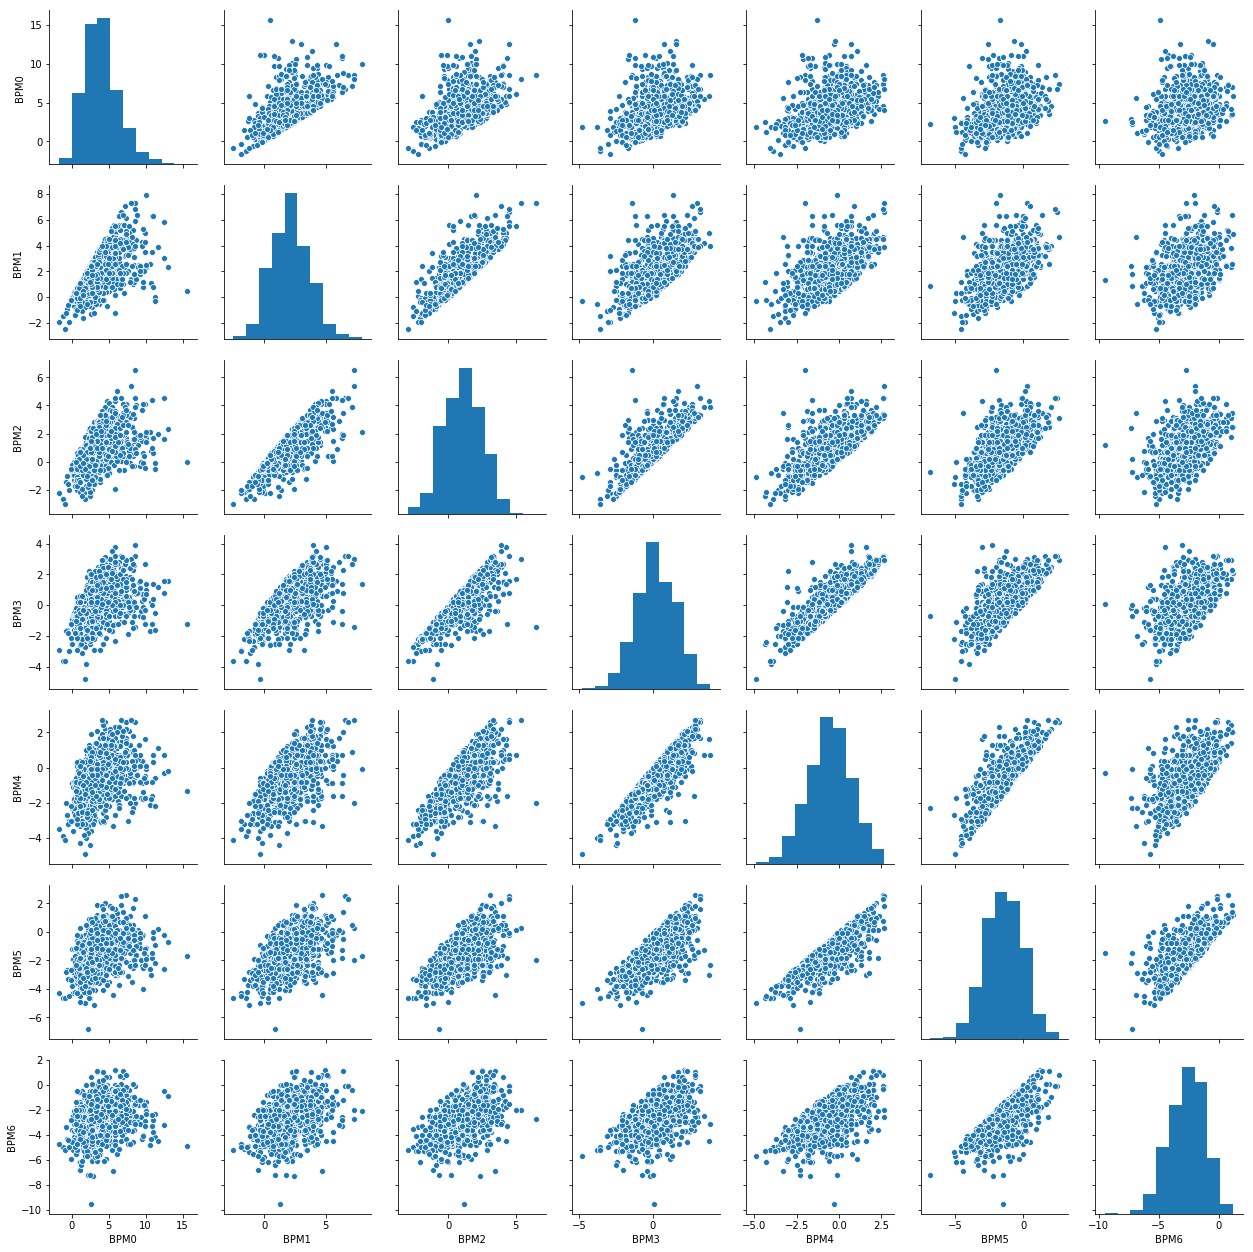

In [54]:
sns.pairplot(win_loss, vars=["BPM" + str(i) for i in range(7)])

### This lack of colinearity between the BPM's for the players on a team make it a good metric for the type of modeling that we're doing here.

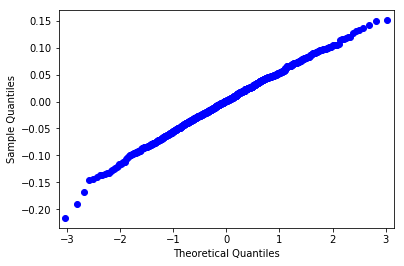

In [55]:
sm.qqplot(model_simplified.resid);

## As our QQ plot appears linear, our choice of a linear model seems to be a good one.

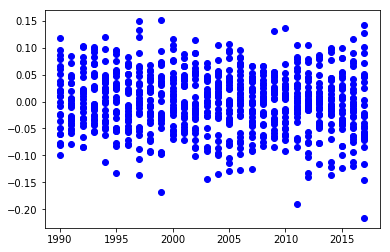

In [56]:
plt.plot(win_loss.Year, model_simplified.resid, 'bo');

## When we plot the residual values against the year, we can see that it is fairly uniformly distributed, meaning that our model seems to be a good one for the timeframe of 1990 - 2017, and doesn't favor any time period over another. 

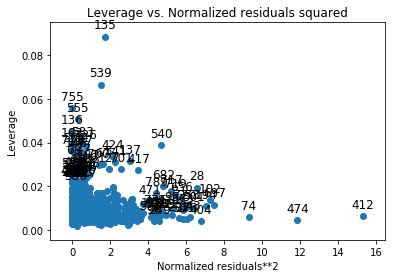

In [57]:
sm.graphics.plot_leverage_resid2(model_simplified);

## The leverage vs. residual plot doesn't show any noticeably high leverage, high residual points. But let's check a few of these points anyways.

In [48]:
yhat = model_simplified.predict(win_loss)
print("Predicted win percentage:", yhat[412])
print(win_loss.iloc[412][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.5339837218114312
Team                   Heat
Year                   2017
Record                14-30
Win_Pct               0.318
Player0        Goran Dragic
BPM0                    2.7
Player1       James Johnson
BPM1                    2.7
Player2       Tyler Johnson
BPM2                    1.5
Player3     Josh Richardson
BPM3                    0.2
Player4     Wayne Ellington
BPM4                   -0.2
Player5     Rodney McGruder
BPM5                   -0.4
Player6    Hassan Whiteside
BPM6                   -0.5
Name: 412, dtype: object


In [58]:
yhat = model_simplified.predict(win_loss)
print("Predicted win percentage:", yhat[474])
print(win_loss.iloc[474][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.39700075738185603
Team           Timberwolves
Year                   2011
Record                17-65
Win_Pct               0.207
Player0          Kevin Love
BPM0                    3.7
Player1    Anthony Tolliver
BPM1                    0.4
Player2        Luke Ridnour
BPM2                   -0.3
Player3       Darko Milicic
BPM3                   -0.8
Player4      Wesley Johnson
BPM4                   -1.6
Player5        Corey Brewer
BPM5                   -1.9
Player6     Michael Beasley
BPM6                   -2.4
Name: 474, dtype: object


## Both of the largest residual points were over predictions of about 20%. This isn't bad at all. There we're no example of the model predicting really good teams to be really bad, or vice versa. 

## BPM and other advanced metrics tend to favor offense, as offensive contributions (namely points) are much easier to quantify statistically than defensive contributions. For example, an excellent defender may reduce their opponent's FG% significantly, but this is not reflected in BPM. 

## Because of this, I suspect that some of the residual is from teams that were good on offense, but poor defensively. For example. a quick google search for the 2011 Timberwolves led me to one journalists description: "There's nowhere near an amount of words to describe the defensive effort, skill and intensity that was nonexistant on this team. Absolutely absymal, utterly ugly and just horrific. An embarrassment on this end of the floor."

## I'm happy with the model's prediction capabilities at the fringes as well. It comes pretty close to predicting the win percentages for the two winningest teams in history, which were both stacked with high BPM players.

In [65]:
yhat = model_simplified.predict(win_loss)
print("Predicted win percentage:", yhat[131])
print(win_loss.iloc[131][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.9303609858279402
Team                Bulls
Year                 1996
Record              72-10
Win_Pct             0.878
Player0    Michael Jordan
BPM0                  8.6
Player1    Scottie Pippen
BPM1                  6.8
Player2        Toni Kukoc
BPM2                  4.5
Player3     Dennis Rodman
BPM3                  3.2
Player4        Ron Harper
BPM4                  2.6
Player5        Steve Kerr
BPM5                  2.3
Player6       Luc Longley
BPM6                 -0.1
Name: 131, dtype: object


In [66]:
print("Predicted win percentage:", yhat[251])
print(win_loss.iloc[251][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.9038439264517109
Team               Warriors
Year                   2016
Record                 73-9
Win_Pct                0.89
Player0       Stephen Curry
BPM0                   12.5
Player1      Draymond Green
BPM1                    5.8
Player2        Andrew Bogut
BPM2                    4.5
Player3      Andre Iguodala
BPM3                    1.6
Player4       Klay Thompson
BPM4                    0.7
Player5     Harrison Barnes
BPM5                   -0.2
Player6    Shaun Livingston
BPM6                   -0.5
Name: 251, dtype: object


## Likewise for really bad teams

In [64]:
print("Predicted win percentage:", yhat[89])
print(win_loss.iloc[89][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'BPM0', 'Player1', 'BPM1', 'Player2', 'BPM2', 'Player3', 'BPM3', 'Player4', 'BPM4', 'Player5', 'BPM5', 'Player6', 'BPM6']])

Predicted win percentage: 0.0615903892679478
Team                Bobcats
Year                   2012
Record               Jul-59
Win_Pct               0.106
Player0        Kemba Walker
BPM0                   -1.2
Player1       Derrick Brown
BPM1                   -1.5
Player2    Gerald Henderson
BPM2                   -2.6
Player3       D.J. Augustin
BPM3                   -3.6
Player4     Bismack Biyombo
BPM4                   -3.9
Player5          D.J. White
BPM5                   -4.6
Player6       Byron Mullens
BPM6                     -5
Name: 89, dtype: object


## The PER model is a lot more conservative for really good/bad teams.

In [70]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[251])
print(win_loss.iloc[251][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.7591672167330578
Team               Warriors
Year                   2016
Record                 73-9
Win_Pct                0.89
Player0       Stephen Curry
PER0                   31.5
Player1      Draymond Green
PER1                   19.3
Player2        Andrew Bogut
PER2                   15.9
Player3      Andre Iguodala
PER3                   12.2
Player4       Klay Thompson
PER4                   18.6
Player5     Harrison Barnes
PER5                   12.3
Player6    Shaun Livingston
PER6                   13.8
Name: 251, dtype: object


In [69]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[131])
print(win_loss.iloc[131][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.8005717529951831
Team                Bulls
Year                 1996
Record              72-10
Win_Pct             0.878
Player0    Michael Jordan
PER0                 29.4
Player1    Scottie Pippen
PER1                   21
Player2        Toni Kukoc
PER2                 20.4
Player3     Dennis Rodman
PER3                 13.6
Player4        Ron Harper
PER4                 14.4
Player5        Steve Kerr
PER5                 15.2
Player6       Luc Longley
PER6                 11.9
Name: 131, dtype: object


In [71]:
yhat1 = model_per.predict(win_loss)
print("Predicted win percentage:", yhat1[89])
print(win_loss.iloc[89][['Team', 'Year', 'Record', 'Win_Pct', 'Player0', 'PER0', 'Player1', 'PER1', 'Player2', 'PER2', 'Player3', 'PER3', 'Player4', 'PER4', 'Player5', 'PER5', 'Player6', 'PER6']])

Predicted win percentage: 0.26058732023663367
Team                Bobcats
Year                   2012
Record               Jul-59
Win_Pct               0.106
Player0        Kemba Walker
PER0                   14.9
Player1       Derrick Brown
PER1                   14.7
Player2    Gerald Henderson
PER2                     14
Player3       D.J. Augustin
PER3                   14.1
Player4     Bismack Biyombo
PER4                   10.6
Player5          D.J. White
PER5                   12.4
Player6       Byron Mullens
PER6                     13
Name: 89, dtype: object


## From this analysis, PER is certainly less effective at predicticting team success from individual stats. I think this is based on it's poor range compared to BPM. For example: by BPM, Steph Curry was much better in 2016 (12.5 BPM)  than Michael Jordan was in 1996 (8.6 BPM), but the two are hardly separated at all in terms of PER (31.5 vs 29.4). Based on this I would argue that BPM should be favored over PER in general for evaluating player contributions